In [55]:
# NOTE: GermanQuAD predictions seem to be okay generally
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'scripts', 'utils')))
import utils

predictions_path = "model_results/tuned/bert-large-cased-whole-word-masking-finetuned-squad_G_predictions.json"
dataset_path = "data/GermanQuAD/GermanQuAD_test.json"
is_valid = utils.validate_predictions(predictions_path, dataset_path)
if is_valid:
    print("Predictions file is valid.")
else:
    print("Predictions file is invalid.")

Total IDs in dataset: 2204
Total IDs in predictions: 2204
Missing IDs in predictions: 0
Missing IDs in dataset: 0
Predictions file is valid.


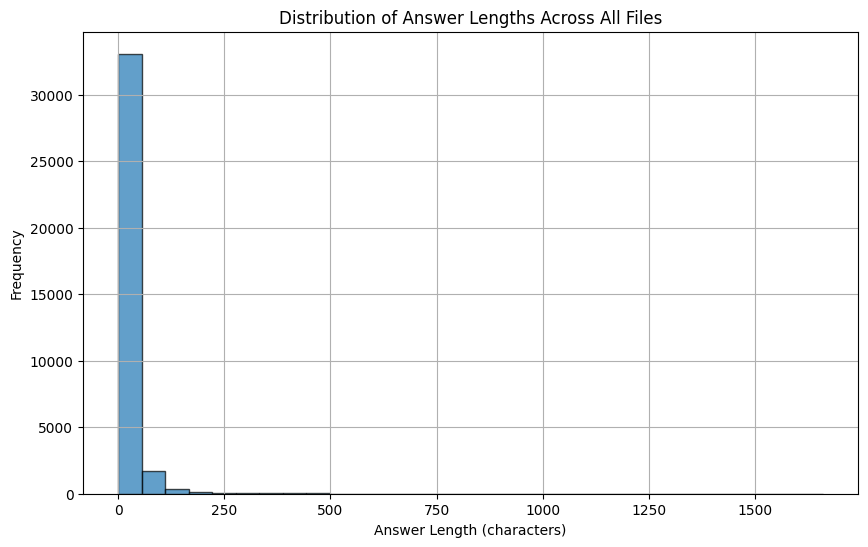

In [22]:
# NOTE: 
# I've been checking the distribution of answer lenghts for 
# fine-tuned models to make a feasible yet sufficiently high assumption
# on max_new_tokens (answer length) in base.py
# --> 250 seems sufficient here for the majority of questions
import utils

# Add directory to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'scripts', 'utils')))

utils.plot_answer_length_distribution('model_results/tuned')

In [52]:

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Define dataset
dataset = "SQuAD"

# Manual dictionary for model names
manual_model_name_map = {
    # base SQuAD
    'Llama3-ChatQA-1.5-8B': 'llama3-8b\n(8B)', 
    'falcon-7b-instruct': 'falcon-7b\n(7B)',
    
    # tuned: SQuAD
    'bert': 'bert\n(?)',
    'bert-large-cased-whole-word-masking-finetuned-squad': 'largeBERT\n(336M)',
    'distilbert-base-cased-distilled-squad': 'distilBERT\n(65M)',
    'mdeberta-v3-base-squad2': 'mdeBERTa\n(278M)',
    'roberta-base-squad2': 'roBERTa_base\n(124M)',
    'roberta-large-squad2': 'roBERTa_large\n(354M)',
    'xlm-roberta-base-squad2': 'xlm_roBERTa_base\n(277M)', 
    
    # Gtuned: SQuAD
    'bert-multi-english-german-squad2': 'multilang_BERT\n(177M)', 
    'gelectra-base-germanquad-distilled': 'GElectra_distil\n(109M)', 
    'gelectra-base-germanquad': 'GElectra_base\n(109M)', 
    'gelectra-large-germanquad': 'GElectra_large\n(335M)', 
}

# Function to load timing results
def load_timing_results(timing_results_path):
    with open(timing_results_path, 'r') as f:
        timing_results = json.load(f)
    return timing_results

# Function to load json files and extract relevant information
def load_json_files(base_dir, subdirs, dataset):
    results = []
    model_name_map = {}
    for subdir in subdirs:
        subdir_path = os.path.join(base_dir, subdir)
        for file_name in os.listdir(subdir_path):
            if file_name.endswith('_eval_results.json'):
                with open(os.path.join(subdir_path, file_name), 'r') as f:
                    data = json.load(f)
                    
                    # Model Name
                    model_name = file_name.replace('_eval_results.json', '')
                    short_name = manual_model_name_map.get(model_name, model_name.split('-')[0])
                    model_name_map[short_name] = model_name
                    
                    # Evaluation script for SQuAD v2 / GermanQuAD
                    eval_v2 = data.get(dataset, {}).get('evaluate-v2', {})
                    exact = eval_v2.get('exact', 0) / 100  # Rescale to 0-1
                    f1 = eval_v2.get('f1', 0) / 100  # Rescale to 0-1
                    
                    # HasAns metrics
                    has_ans_exact = eval_v2.get('HasAns_exact', 0) / 100
                    has_ans_f1 = eval_v2.get('HasAns_f1', 0) / 100
                    
                    # NoAns metrics
                    no_ans_exact = eval_v2.get('NoAns_exact', 0)
                    no_ans_f1 = eval_v2.get('NoAns_f1', 0)
                    
                    # BLEU 
                    bleu_score = data.get(dataset, {}).get('bleu', {}).get('HasAns_bleu', 0)
                    
                    # ROUGE
                    rouge_scores = data.get(dataset, {}).get('rouge', {}).get('HasAns_rouge', {})
                    rouge1 = rouge_scores.get('rouge1', {}).get('f', 0)
                    rouge2 = rouge_scores.get('rouge2', {}).get('f', 0)
                    rougeL = rouge_scores.get('rougeL', {}).get('f', 0)
                    rouge_score = np.mean([rouge1, rouge2, rougeL])
                    
                    # BERT
                    bert_score = data.get(dataset, {}).get('bertscore', {}).get('HasAns_BERTScore', {}).get('F1', 0)
                    
                    # Cumulative scores 
                    eval_v2_score = 1/2 * (exact + f1)
                    eval_v2_score_hasAns =  1/2 * (has_ans_exact + has_ans_f1)
                    eval_other = 1/3 * (bert_score + bleu_score + rouge_score)
                    overall_score = 1/2 * (eval_v2_score_hasAns + eval_other)
                    
                    results.append({
                        'short_name': short_name,
                        'model': model_name,
                        'exact': exact,
                        'f1': f1,
                        'has_ans_exact': has_ans_exact,
                        'has_ans_f1': has_ans_f1,
                        'no_ans_exact': no_ans_exact,
                        'no_ans_f1': no_ans_f1,
                        'bleu_score': bleu_score,
                        'rouge_score': rouge_score,
                        'bert_score': bert_score,
                        'eval_v2_score': eval_v2_score,
                        'eval_v2_score_hasAns': eval_v2_score_hasAns, 
                        'eval_other': eval_other,
                        'overall_score': overall_score
                    })
    return results, model_name_map

,short_name,model,exact,f1,has_ans_exact,has_ans_f1,no_ans_exact,no_ans_f1,bleu_score,rouge_score,bert_score,eval_v2_score,eval_v2_score_hasAns,eval_other,overall_score,SQuAD,G
0,llama3-8b\n(8B),Llama3-ChatQA-1.5-8B,0.147225,0.266115,0.281883,0.520003,1.295206,1.295206,0.000000,0.000000,0.000000,0.206670,0.400943,0.000000,0.200471,NaN,NaN
1,falcon-7b\n(7B),falcon-7b-instruct,0.055504,0.113179,0.095648,0.211163,1.547519,1.547519,0.164505,0.160914,0.842516,0.084342,0.153406,0.389312,0.271359,NaN,NaN
2,bert,bert-finetuned-squad,0.369325,0.419758,0.710020,0.811030,2.960471,2.960471,0.000000,0.000000,0.000000,0.394542,0.760525,0.000000,0.380263,NaN,NaN
9,GElectra_base\n(109M),gelectra-base-germanquad,0.207530,0.296117,0.339744,0.517172,7.569386,7.569386,0.409620,0.438601,0.835793,0.251823,0.428458,0.561338,0.494898,1909.539432,665.030208
10,GElectra_distil\n(109M),gelectra-base-germanquad-distilled,0.205677,0.295748,0.338900,0.519302,7.283431,7.283431,0.417757,0.443451,0.845559,0.250713,0.429101,0.568922,0.499012,1889.306097,660.343249
11,GElectra_large\n(335M),gelectra-large-germanquad,0.279963,0.379442,0.502193,0.701437,5.836838,5.836838,0.568540,0.593387,0.904350,0.329703,0.601815,0.688759,0.645287,5888.141892,1986.069657
4,distilBERT\n(65M),distilbert-base-cased-distilled-squad,0.362335,0.410843,0.703779,0.800935,2.186712,2.186712,0.675465,0.677588,0.932448,0.386589,0.752357,0.761834,0.757095,1111.990184,669.699848
5,xlm_roBERTa_base\n(277M),xlm-roberta-base-squad2,0.393245,0.434806,0.787618,0.870859,0.000000,0.000000,0.626358,0.687228,0.942047,0.414026,0.829238,0.751878,0.790558,1065.315740,754.472385
12,multilang_BERT\n(177M),bert-multi-english-german-squad2,0.381033,0.420085,0.757422,0.835640,0.571909,0.571909,0.743808,0.734815,0.946618,0.400559,0.796531,0.808414,0.802472,2087.638945,635.803910
7,largeBERT\n(336M),bert-large-cased-whole-word-masking-finetuned-...,0.399815,0.444165,0.771930,0.860758,2.876367,2.876367,0.732713,0.731751,0.950770,0.421990,0.816344,0.805078,0.810711,5821.237135,2609.031781


,Short Name,Full Name
0,llama3-8b\n(8B),Llama3-ChatQA-1.5-8B
1,falcon-7b\n(7B),falcon-7b-instruct
2,bert,bert-finetuned-squad
3,roBERTa_base\n(124M),roberta-base-squad2
4,distilBERT\n(65M),distilbert-base-cased-distilled-squad
5,xlm_roBERTa_base\n(277M),xlm-roberta-base-squad2
6,mdeBERTa\n(278M),mdeberta-v3-base-squad2
7,largeBERT\n(336M),bert-large-cased-whole-word-masking-finetuned-...
8,roBERTa_large\n(354M),roberta-large-squad2
9,GElectra_base\n(109M),gelectra-base-germanquad


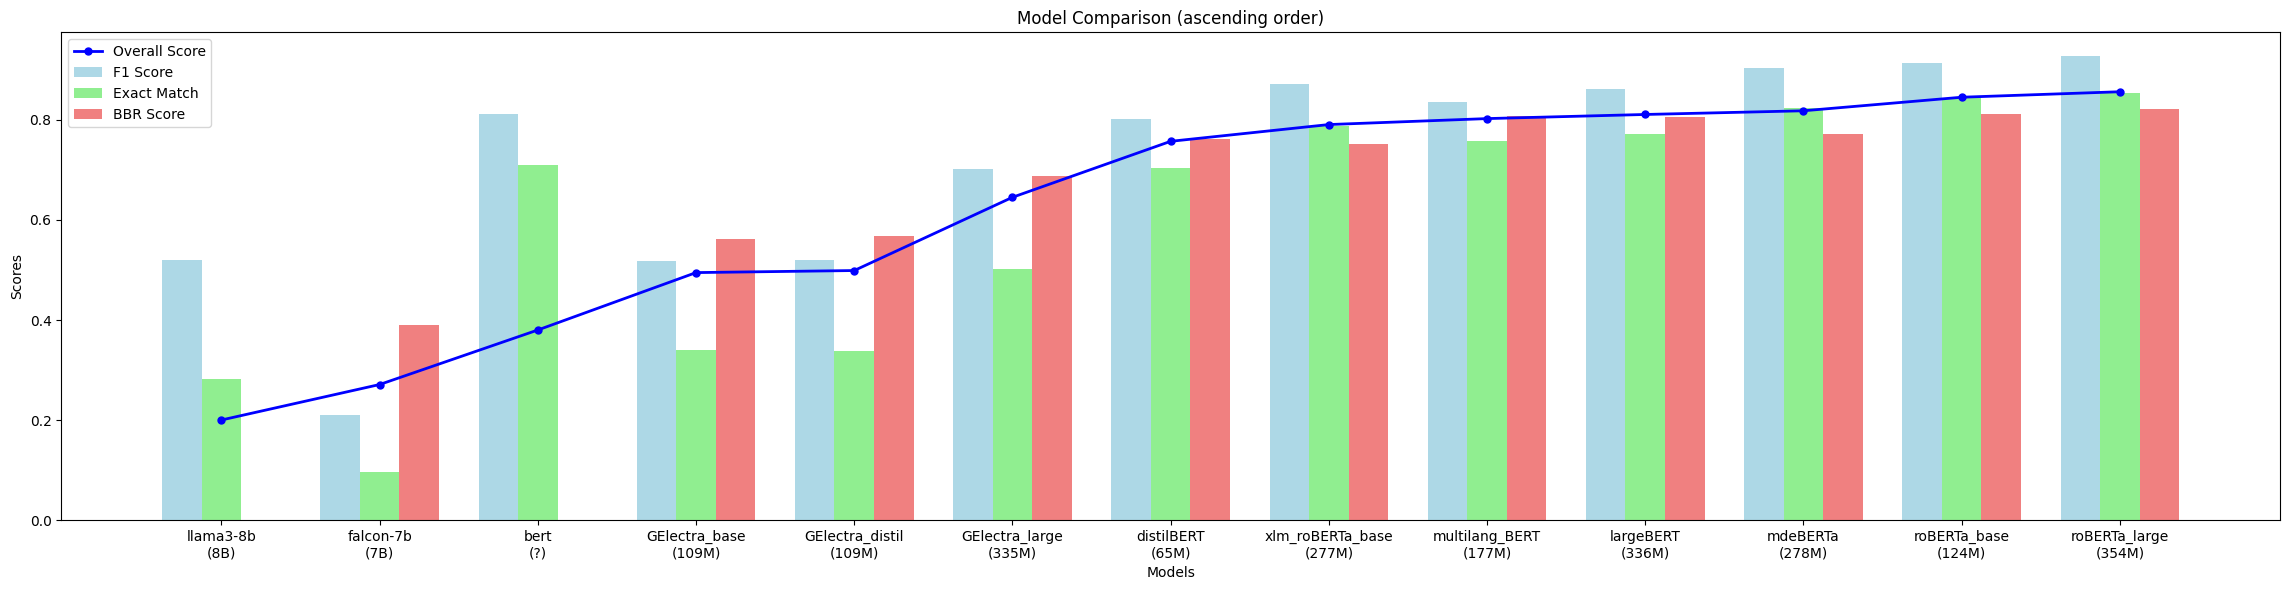

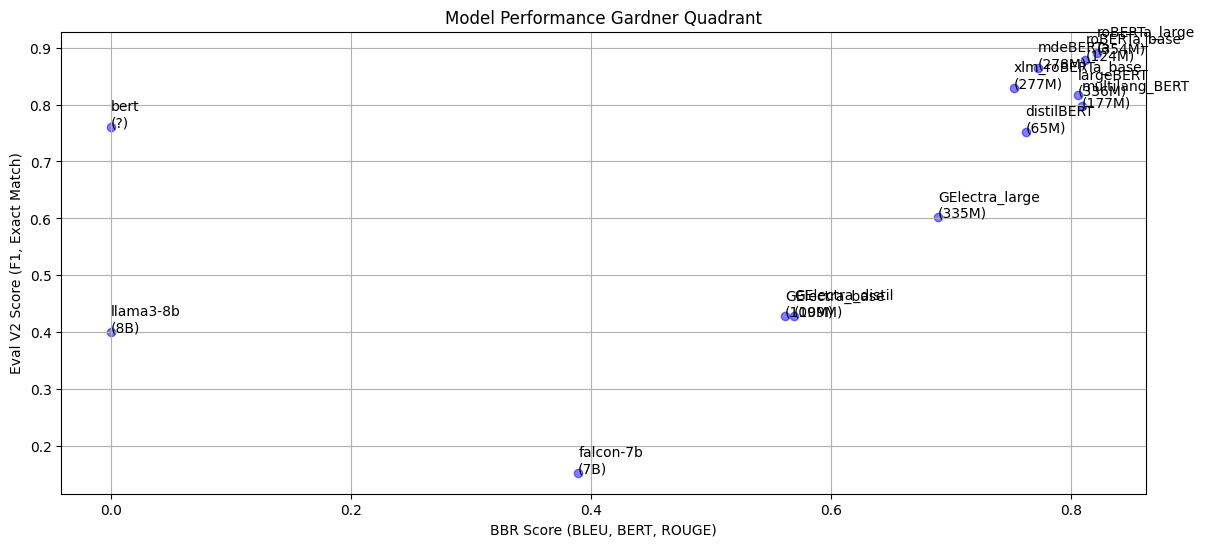

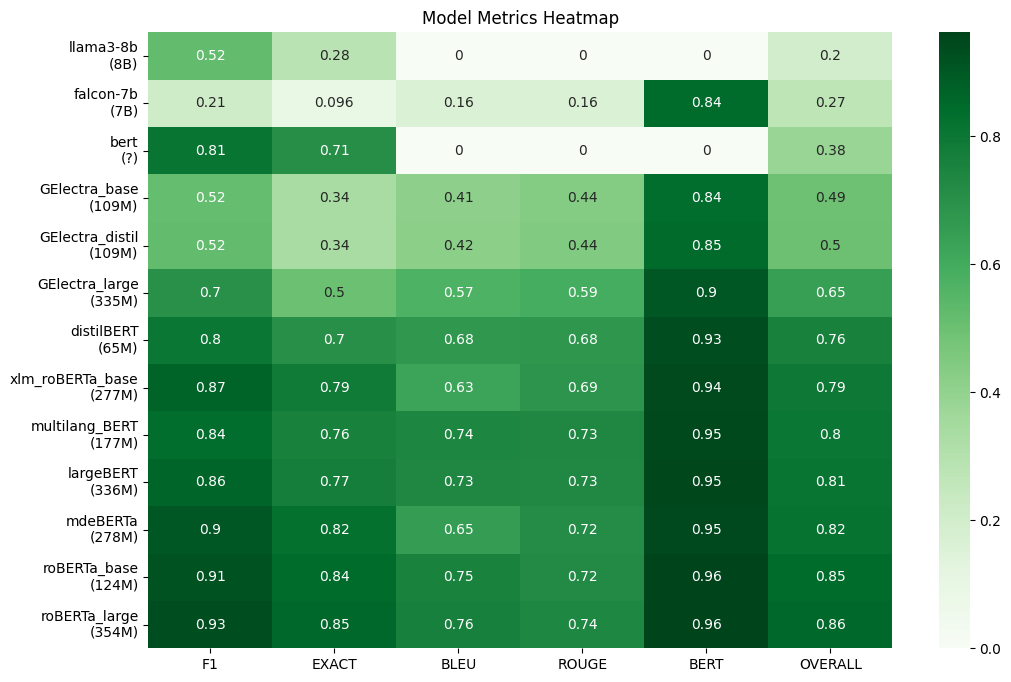

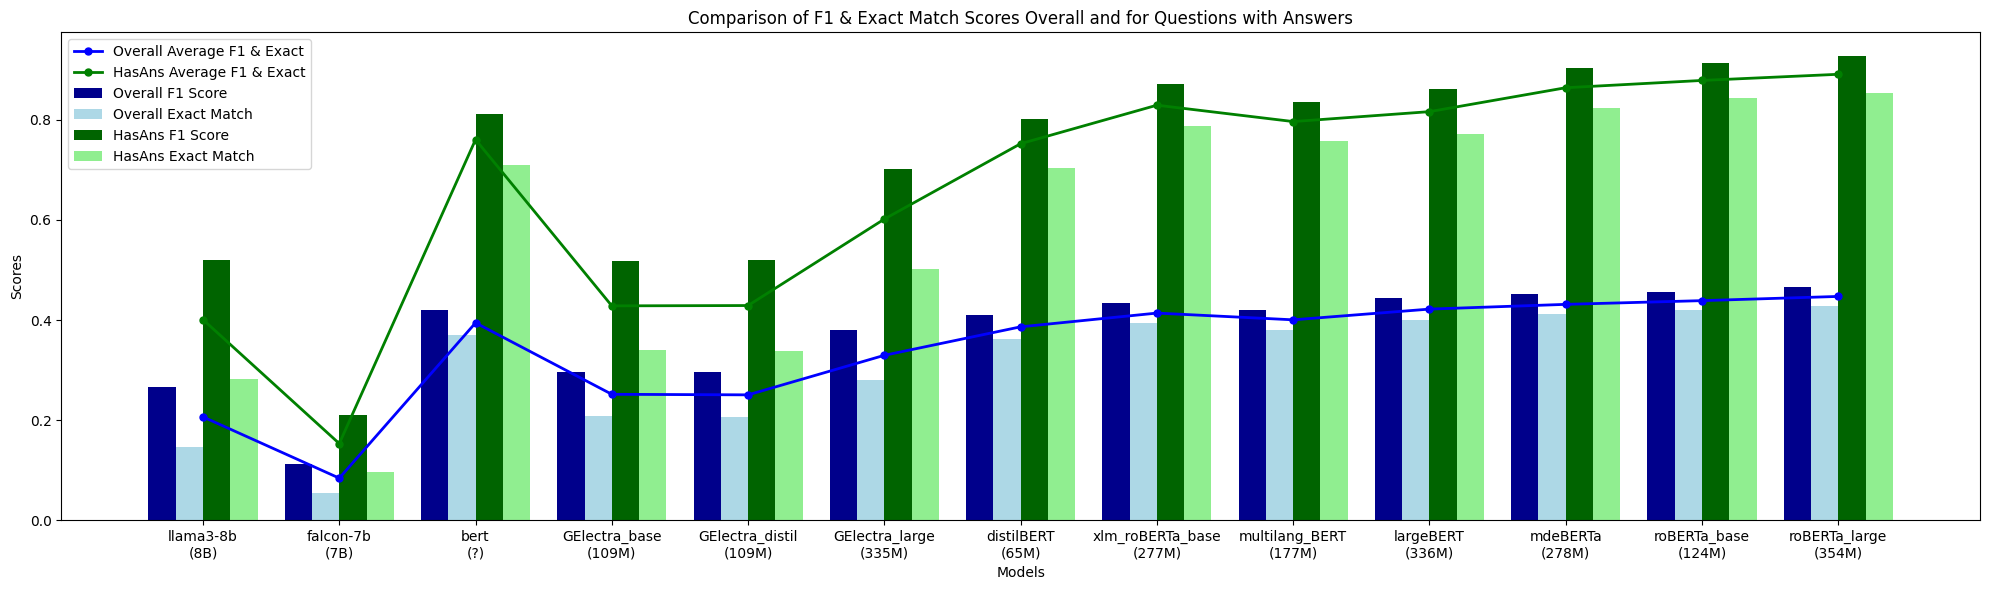

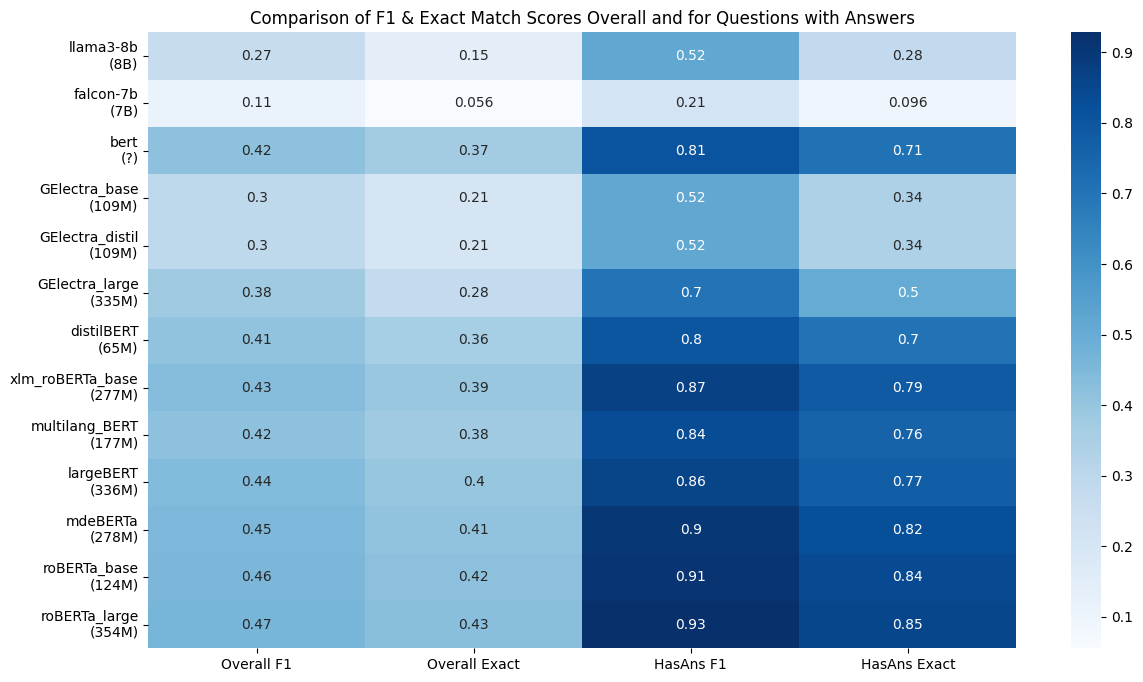

/var/folders/dc/gm62hfbx64d0f98rqwpt3s_h0000gn/T/ipykernel_29725/3564902229.py:168: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = timing_data.applymap(lambda x: f"{x:,}s" if isinstance(x, int) else f"{int(x):,}s")


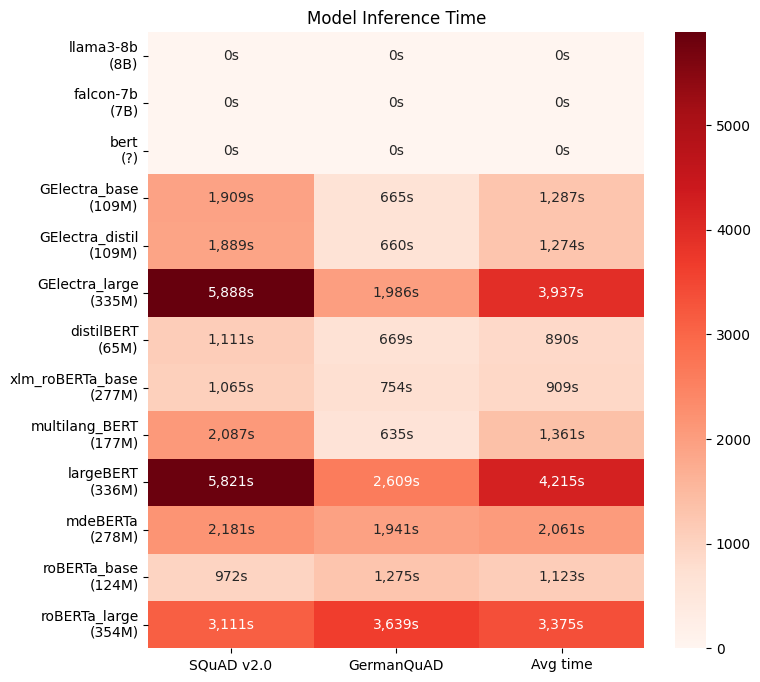

In [56]:
# Define the directory paths
base_dir = './eval_results'
figure_root = './figures'
timing_results_path = './timing_results.json'

# Select the subdirectory
subdir = ['base', 'tuned', 'Gtuned'] # options: base, Gbase, tuned, Gtuned

# Load data
dataset = "SQuAD"
data, model_name_map = load_json_files(base_dir, subdir, dataset)

# Load timing results
timing_results = load_timing_results(timing_results_path)

# Create and display DataFrame
df = pd.DataFrame(data)
timing_df = pd.DataFrame.from_dict(timing_results, orient='index').reset_index()
timing_df = timing_df.rename(columns={'index': 'model'})
df = pd.merge(df, timing_df, on='model', how='left')

df_sorted = df.sort_values(by='overall_score')
display(df_sorted)
display(pd.DataFrame(list(model_name_map.items()), columns=['Short Name', 'Full Name']))

# ============================================================================================
# Visualisation 1: Bar chart with line graph for overall_score
plt.figure(figsize=(23, 6))
bar_width = 0.25
index = np.arange(len(df_sorted))

# Bar chart for F1 Score, Exact Match, and Eval Other with subtle colors
plt.bar(index, df_sorted['has_ans_f1'], bar_width, label='F1 Score', color='lightblue')
plt.bar(index + bar_width, df_sorted['has_ans_exact'], bar_width, label='Exact Match', color='lightgreen')
plt.bar(index + 2 * bar_width, df_sorted['eval_other'], bar_width, label='BBR Score', color='lightcoral')

# Line graph for Overall Score with a subtle color
plt.plot(index + bar_width, df_sorted['overall_score'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Overall Score')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison (ascending order)')
plt.xticks(index + bar_width, [manual_model_name_map.get(name, name) for name in df_sorted['short_name']], rotation=0)
plt.legend()

plt.tight_layout()

# SAVE ⬇️
save_path = os.path.join(figure_root, 'overall-bar-chart.png')
plt.savefig(save_path)

plt.show()

# ============================================================================================
# Visualisation 2: Gardner Quadrants Style graph
plt.figure(figsize=(14, 6))
plt.scatter(df_sorted['eval_other'], df_sorted['eval_v2_score_hasAns'], c='b', alpha=0.5)
for i, txt in enumerate(df_sorted['short_name']):
    plt.annotate(manual_model_name_map.get(txt, txt), (df_sorted['eval_other'].iat[i], df_sorted['eval_v2_score_hasAns'].iat[i]))

plt.xlabel('BBR Score (BLEU, BERT, ROUGE)')
plt.ylabel('Eval V2 Score (F1, Exact Match)')
plt.title('Model Performance Gardner Quadrant')

plt.grid(True)

# SAVE ⬇️
save_path = os.path.join(figure_root, 'overall-gardner.png')
plt.savefig(save_path)

plt.show()

# ============================================================================================
# Visualisation 3: Heat map
plt.figure(figsize=(12, 8))

# Select and rename the columns for the heatmap
heat_data = df_sorted[['short_name', 'has_ans_f1', 'has_ans_exact', 'bleu_score', 'rouge_score', 'bert_score', 'overall_score']].set_index('short_name')
heat_data.columns = ['F1' if col == 'has_ans_f1' else 'EXACT' if col == 'has_ans_exact' else col.split('_')[0].upper() for col in heat_data.columns] 
heat_data.index = [manual_model_name_map.get(name, name) for name in heat_data.index]

# Create the heatmap
sns.heatmap(heat_data, annot=True, cmap='Greens')

plt.title('Model Metrics Heatmap')

# SAVE ⬇️
save_path = os.path.join(figure_root, 'overall-heatmap.png')
plt.savefig(save_path)

plt.show()

# ============================================================================================
# Visualisation 4: Bar chart to compare overall exact and f1 with HasAns exact and f1
df_sorted = df.sort_values('overall_score')
plt.figure(figsize=(20, 6))
bar_width = 0.2
index = np.arange(len(df_sorted))

# Bar chart for Overall F1 Score, Overall Exact Match, HasAns F1 Score, and HasAns Exact Match with subtle colors
plt.bar(index, df_sorted['f1'], bar_width, label='Overall F1 Score', color='darkblue')
plt.bar(index + bar_width, df_sorted['exact'], bar_width, label='Overall Exact Match', color='lightblue')
plt.bar(index + 2 * bar_width, df_sorted['has_ans_f1'], bar_width, label='HasAns F1 Score', color='darkgreen')
plt.bar(index + 3 * bar_width, df_sorted['has_ans_exact'], bar_width, label='HasAns Exact Match', color='lightgreen')

# Calculate eval_v2_score and eval_v2_score_hasAns
df_sorted['eval_v2_score'] = 0.5 * (df_sorted['exact'] + df_sorted['f1'])
df_sorted['eval_v2_score_hasAns'] = 0.5 * (df_sorted['has_ans_exact'] + df_sorted['has_ans_f1'])

# Plot lines for eval_v2_score and eval_v2_score_hasAns
plt.plot(index + 1.5 * bar_width, df_sorted['eval_v2_score'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Overall Average F1 & Exact')
plt.plot(index + 1.5 * bar_width, df_sorted['eval_v2_score_hasAns'], color='green', marker='o', linestyle='-', linewidth=2, markersize=5, label='HasAns Average F1 & Exact')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of F1 & Exact Match Scores Overall and for Questions with Answers')
plt.xticks(index + 1.5 * bar_width, [manual_model_name_map.get(name, name) for name in df_sorted['short_name']], rotation=0)
plt.legend()

plt.tight_layout()

# SAVE ⬇️
save_path = os.path.join(figure_root, 'evaluate-v2-bar-chart.png')
plt.savefig(save_path)

plt.show()

# ============================================================================================
# Visualisation 5: Heat map to compare overall exact and f1 with HasAns exact and f1
plt.figure(figsize=(14, 8))

# Select and rename the columns for the heatmap
heat_data_comparison = df_sorted[['short_name', 'f1', 'exact', 'has_ans_f1', 'has_ans_exact']].set_index('short_name')
heat_data_comparison.columns = ['Overall F1', 'Overall Exact', 'HasAns F1', 'HasAns Exact']

# Update index labels with manual model name map
heat_data_comparison.index = [manual_model_name_map.get(name, name) for name in heat_data_comparison.index]

# Create the heatmap
sns.heatmap(heat_data_comparison, annot=True, cmap='Blues')

plt.title('Comparison of F1 & Exact Match Scores Overall and for Questions with Answers')

# SAVE ⬇️
save_path = os.path.join(figure_root, 'evaluate-v2-heatmap.png')
plt.savefig(save_path)

plt.show()

# ============================================================================================
# Visualisation 6: Heat map for timing results
plt.figure(figsize=(8, 8))

# Extract timing results and reshape data
timing_data = df_sorted[['short_name', 'SQuAD', 'G']].set_index('short_name')
timing_data.columns = ['SQuAD v2.0', 'GermanQuAD']

# Update index labels with manual model name map
timing_data.index = [manual_model_name_map.get(name, name) for name in timing_data.index]

# Convert times to integers and round down
timing_data = timing_data.fillna(0).astype(int)

# Calculate the average time
timing_data['Avg time'] = timing_data.mean(axis=1)

# Create annotations with formatted times and scores
annotations = timing_data.applymap(lambda x: f"{x:,}s" if isinstance(x, int) else f"{int(x):,}s")

# Create the heatmap
sns.heatmap(timing_data, annot=annotations, fmt='', cmap='Reds')

plt.title('Model Inference Time')

# Rotate the axis descriptions by 90°
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# SAVE ⬇️
save_path = os.path.join(figure_root, 'timing-results-heatmap.png')
plt.savefig(save_path)

plt.show()